# What Does Your Smartphone Know About You?

[Video-Discussion of this notebook](https://youtu.be/mCS1bmB0A-s)

In this notebook I will try to extract as much information about the smartphone user as possible.<br>
Feel free to suggest new ideas for exploration.

30 participants performed activities of daily living while carrying a waist-mounted smartphone. The phone was configured to record two implemented sensors (accelerometer and gyroscope). For these time series the directors of the underlying study performed feature generation and generated the dataset by moving a fixed-width window of 2.56s over the series. Since the windows had 50% overlap the resulting points are equally spaced (1.28s).

[1 Import Libraries](#1)    
[2 Load Data](#2)    
[3 Dataset Exploration](#3)    
&nbsp;&nbsp;&nbsp;&nbsp;[3.1 Which Features Are There?](#3.1)    
&nbsp;&nbsp;&nbsp;&nbsp;[3.2 What Types Of Data Are There?](#3.2)    
&nbsp;&nbsp;&nbsp;&nbsp;[3.3 How Are The Labels Distributed?](#3.3)    
[4 Activity Exploration](#4)    
&nbsp;&nbsp;&nbsp;&nbsp;[4.1 Are The Activities Separable?](#4.1)    
&nbsp;&nbsp;&nbsp;&nbsp;[4.2 How Good Are The Activities Separable?](#4.2)    
[5 Participant Exploration](#5)    
&nbsp;&nbsp;&nbsp;&nbsp;[5.1 How Good Are the Participants Separable?](#5.1)    
&nbsp;&nbsp;&nbsp;&nbsp;[5.2 How Long Does The Smartphone Gather Data For This Accuracy?](#5.2)    
&nbsp;&nbsp;&nbsp;&nbsp;[5.3 Which Sensor Is More Important For Classifying Participants By Walking Style?](#5.3)    
&nbsp;&nbsp;&nbsp;&nbsp;[5.4 How Long Does The Participant Use The Staircase?](#5.4)    
&nbsp;&nbsp;&nbsp;&nbsp;[5.5 How Much Does The Up-/Downstairs Ratio Vary?](#5.5)    
&nbsp;&nbsp;&nbsp;&nbsp;[5.6 Are There Conspicuities In The Staircase Walking Duration Distribution?](#5.6)    
&nbsp;&nbsp;&nbsp;&nbsp;[5.7 Is There A Unique Walking Style For Each Participant?](#5.7)    
&nbsp;&nbsp;&nbsp;&nbsp;[5.8 How Long Does The Participant Walk?](#5.8)    
&nbsp;&nbsp;&nbsp;&nbsp;[5.9 Is There A Unique Staircase Walking Style For Each Participant?](#5.9)    
[6 Exploring Personal Information](#6)    
&nbsp;&nbsp;&nbsp;&nbsp;[6.1 What Is The Walking Frequency Of A Single Participant?](#6.1)    
&nbsp;&nbsp;&nbsp;&nbsp;[6.2 What Is The Walking Frequency Of Both Found Speeds?](#6.2)    
&nbsp;&nbsp;&nbsp;&nbsp;[6.3 What Are The Frequencies In A Self-Experiment?](#6.3)    
[7 Conclusion](#7)    

## <a id=1>Import Libraries</a>

In [3]:
# To store data
import pandas as pd

# To do linear algebra
import numpy as np
from numpy import pi

# To create plots
from matplotlib.colors import rgb2hex
from matplotlib.cm import get_cmap
import matplotlib.pyplot as plt

# To create nicer plots
import seaborn as sns

# To create interactive plots
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

# To get new datatypes and functions
from collections import Counter
from cycler import cycler

# To investigate distributions
from scipy.stats import norm, skew, probplot
from scipy.optimize import curve_fit

# To build models
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# To gbm light
from lightgbm import LGBMClassifier, Booster

# To measure time
from time import time

## <a id=2>Load Data</a>

In [4]:
# Load datasets
train_df = pd.read_csv('../data/train.csv')
test_df = pd.read_csv('../data/test.csv')

# Combine boths dataframes
train_df['Data'] = 'Train'
test_df['Data'] = 'Test'
both_df = pd.concat([train_df, test_df], axis=0).reset_index(drop=True)
both_df['subject'] = '#' + both_df['subject'].astype(str)

# Create label
label = both_df.pop('Activity')

print('Shape Train:\t{}'.format(train_df.shape))
print('Shape Test:\t{}\n'.format(test_df.shape))

train_df.head()

Shape Train:	(7352, 564)
Shape Test:	(2947, 564)



,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity,Data
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,1,STANDING,Train
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,1,STANDING,Train
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118,1,STANDING,Train
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663,1,STANDING,Train
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892,1,STANDING,Train


The directors of the study created an incredible number of features from the two sensors.

## <a id=3>Dataset Exploration</a>
### <a id=3.1>Which Features Are There?</a>

The features seem to have a main name and some information on how they have been computed attached. Grouping the main names will reduce the dimensions for the first impression.

In [5]:
# Group and count main names of columns
pd.DataFrame.from_dict(Counter([col.split('-')[0].split('(')[0] for col in both_df.columns]), orient='index').rename(columns={0:'count'}).sort_values('count', ascending=False)

,count
fBodyAcc,79
fBodyGyro,79
fBodyAccJerk,79
tGravityAcc,40
tBodyAcc,40
tBodyGyroJerk,40
tBodyGyro,40
tBodyAccJerk,40
tBodyAccMag,13
tGravityAccMag,13


Mainly there are 'acceleration' and 'gyroscope' features. A few 'gravity' features are there as well.

Impressive how many features there are in regard of the limited number of sensors used.

### <a id=3.2>What Types Of Data Are There?</a>

In [6]:
# Get null values and dataframe information
print('Null Values In DataFrame: {}\n'.format(both_df.isna().sum().sum()))
both_df.info()

Null Values In DataFrame: 0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10299 entries, 0 to 10298
Columns: 563 entries, tBodyAcc-mean()-X to Data
dtypes: float64(561), object(2)
memory usage: 44.2+ MB


Except from the label and the newly created 'Data' and 'subject' features there is only numerical data. Fortunately there are no missing values.

### <a id=3.3>How Are The Labels Distributed?</a>

In [7]:
# Plotting data
label_counts = label.value_counts()

# Get colors
n = label_counts.shape[0]
colormap = get_cmap('viridis')
colors = [rgb2hex(colormap(col)) for col in np.arange(0, 1.01, 1/(n-1))]

# Create plot
data = go.Bar(x = label_counts.index,
              y = label_counts,
              marker = dict(color = colors))

layout = go.Layout(title = 'Smartphone Activity Label Distribution',
                   xaxis = dict(title = 'Activity'),
                   yaxis = dict(title = 'Count'))

fig = go.Figure(data=[data], layout=layout)
iplot(fig)

Although there are fluctuations in the label counts, the labels are quite equally distributed.

Assuming the participants had to walk the same number of stairs upwards as well as downwards and knowing the smartphones had a constant sampling rate, there should be the same amount of datapoints for walking upstairs and downstairs. <br>
Disregarding the possibility of flawed data, the participants seem to **walk roughly 10% faster downwards.**

## <a id=4>Activity Exploration</a>
### <a id=4.1>Are The Activities Separable?</a>

The dataset is geared towards classifying the activity of the participant. Let us investigate the separability of the classes.

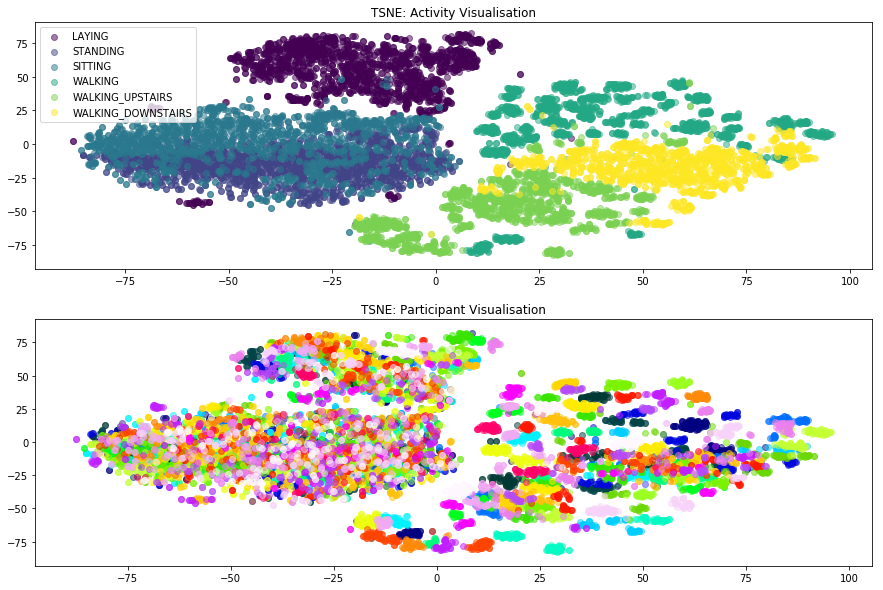

In [8]:
# Create datasets
tsne_data = both_df.copy()
data_data = tsne_data.pop('Data')
subject_data = tsne_data.pop('subject')

# Scale data
scl = StandardScaler()
tsne_data = scl.fit_transform(tsne_data)

# Reduce dimensions (speed up)
pca = PCA(n_components=0.9, random_state=3)
tsne_data = pca.fit_transform(tsne_data)

# Transform data
tsne = TSNE(random_state=3)
tsne_transformed = tsne.fit_transform(tsne_data)


# Create subplots
fig, axarr = plt.subplots(2, 1, figsize=(15,10))

### Plot Activities
# Get colors
n = label.unique().shape[0]
colormap = get_cmap('viridis')
colors = [rgb2hex(colormap(col)) for col in np.arange(0, 1.01, 1/(n-1))]

# Plot each activity
for i, group in enumerate(label_counts.index):
    # Mask to separate sets
    mask = (label==group).values
    axarr[0].scatter(x=tsne_transformed[mask][:,0], y=tsne_transformed[mask][:,1], c=colors[i], alpha=0.5, label=group)
axarr[0].set_title('TSNE: Activity Visualisation')
axarr[0].legend()


### Plot Subjects
# Get colors
n = subject_data.unique().shape[0]
colormap = get_cmap('gist_ncar')
colors = [rgb2hex(colormap(col)) for col in np.arange(0, 1.01, 1/(n-1))]

# Plot each participant
for i, group in enumerate(subject_data.unique()):
    # Mask to separate sets
    mask = (subject_data==group).values
    axarr[1].scatter(x=tsne_transformed[mask][:,0], y=tsne_transformed[mask][:,1], c=colors[i], alpha=0.5, label=group)

axarr[1].set_title('TSNE: Participant Visualisation')
plt.show()

In plot 1 you can clearly see the **activities are mostly separable.**

Plot 2 reveals **personal information** of the participants. Everybody has for example an **unique/sparable walking style** (on the upper right). Therefore the smartphone should be able to **detect what you are doing and also who is using the smartphone** (if you are moving around with it).

### <a id=4.2>How Good Are The Activities Separable?</a>

Without much preprocessing and parameter tuning a simple LGBMClassifier should work decently.

In [15]:
# Split training testing data
enc = LabelEncoder()
label_encoded = enc.fit_transform(label)
X_train, X_test, y_train, y_test = train_test_split(tsne_data, label_encoded, random_state=3)

# Create the model
lgbm = LGBMClassifier(n_estimators=500, random_state=3)
lgbm = lgbm.fit(X_train, y_train)

# Test the model
score = accuracy_score(y_true=y_test, y_pred=lgbm.predict(X_test))
print('Accuracy on testset:\t{:.4f}\n'.format(score))

Accuracy on testset:	0.9553



In [19]:
import time
from sklearn.externals import joblib
# save model
joblib.dump(lgbm, 'lgb.pkl')

#load model
start = time.time()
gbmpkl = joblib.load('lgb.pkl')
end = time.time()
print("load model takes time: {}".format(end-start))

load model takes time: 0.04677987098693848


In [20]:
# Test the model
score = accuracy_score(y_true=y_test, y_pred=gbmpkl.predict(X_test))
print('Accuracy on testset:\t{:.4f}\n'.format(score))

Accuracy on testset:	0.9553



With a basic untuned model the **activity of the smartphone user** can be predicted with an **accuracy of 95%.**<br>
This is pretty striking regarding six equally distributed labels.

**Summary:**<br>
If the smartphone or an App wants to know what you are doing, this is feasible.

## <a id=5>Participant Exploration</a>
### <a id=5.1>How Good Are the Participants Separable?</a>

As we have seen in the second t-SNE plot the separability of the participants seem to vary regarding their activity. Let us investigate this a little bit by fitting the same basic model to the data of each activity separately.

In [8]:
# Store the data
data = []
# Iterate over each activity
for activity in label_counts.index:
    # Create dataset
    act_data = both_df[label==activity].copy()
    act_data_data = act_data.pop('Data')
    act_subject_data = act_data.pop('subject')
    
    # Scale data
    scl = StandardScaler()
    act_data = scl.fit_transform(act_data)

    # Reduce dimensions
    pca = PCA(n_components=0.9, random_state=3)
    act_data = pca.fit_transform(act_data)

    
    # Split training testing data
    enc = LabelEncoder()
    label_encoded = enc.fit_transform(act_subject_data)
    X_train, X_test, y_train, y_test = train_test_split(act_data, label_encoded, random_state=3)


    # Fit basic model
    print('Activity: {}'.format(activity))
    lgbm = LGBMClassifier(n_estimators=500, random_state=3)
    lgbm = lgbm.fit(X_train, y_train)
    
    score = accuracy_score(y_true=y_test, y_pred=lgbm.predict(X_test))
    print('Accuracy on testset:\t{:.4f}\n'.format(score))
    data.append([activity, score])

Activity: LAYING
Accuracy on testset:	0.6481

Activity: STANDING
Accuracy on testset:	0.5493

Activity: SITTING
Accuracy on testset:	0.5303

Activity: WALKING
Accuracy on testset:	0.9513

Activity: WALKING_UPSTAIRS
Accuracy on testset:	0.9249

Activity: WALKING_DOWNSTAIRS
Accuracy on testset:	0.9091



**Detecting the correct participant** regarind their current activity is not alone possible but **astonishing accurate** regarding the 30 different persons **(94% by walking style)**.<br>
Noticable is that the accuracy seems to rise if the participant moves around. This implies a unique walking/movement style for each person.

### <a id=5.2>How Long Does The Smartphone Gather Data For This Accuracy?</a>

The description of the data states; "fixed-width sliding windows of 2.56 sec and 50% overlap" for each datapoint.<br>
Therefore a single datapoint is gathered every 1.28 sec.

In [9]:
# Create duration datafrae
duration_df = (both_df.groupby([label, subject_data])['Data'].count().reset_index().groupby('Activity').agg({'Data':'mean'}) * 1.28).rename(columns={'Data':'Seconds'})
activity_df = pd.DataFrame(data, columns=['Activity', 'Accuracy']).set_index('Activity')
activity_df.join(duration_df)

,Accuracy,Seconds
Activity,,
LAYING,0.648148,82.944000
STANDING,0.549266,81.322667
SITTING,0.530337,75.818667
WALKING,0.951276,73.472000
WALKING_UPSTAIRS,0.924870,65.877333
WALKING_DOWNSTAIRS,0.909091,59.989333


The smartphone is **quite fast (1 - 1.5 min)** in guessing correctly.

### <a id=5.3>Which Sensor Is More Important For Classifying Participants By Walking Style?</a>

I will fit another basic model to the walking data and investigate the feature importances afterwards. Since there are so many features I am going to group them by their sensor (accelerometer = Acc, gyroscope = Gyro)

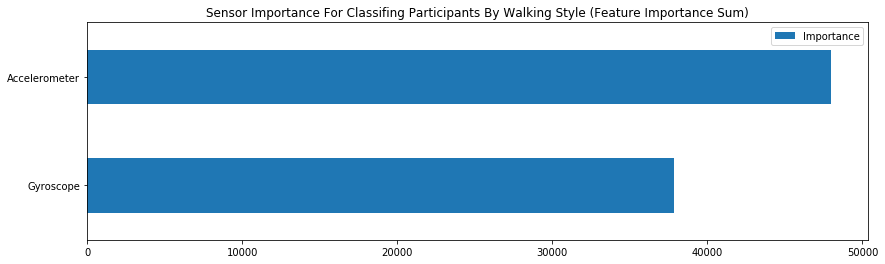

In [10]:
# Create dataset
tsne_data = both_df[label=='WALKING'].copy()
data_data = tsne_data.pop('Data')
subject_data = tsne_data.pop('subject')

# Scale data
scl = StandardScaler()
tsne_data = scl.fit_transform(tsne_data)

# Split training testing data
enc = LabelEncoder()
label_encoded = enc.fit_transform(subject_data)
X_train, X_test, y_train, y_test = train_test_split(tsne_data, label_encoded, random_state=3)


# Create model
lgbm = LGBMClassifier(n_estimators=500, random_state=3)
lgbm = lgbm.fit(X_train, y_train)

# Get importances
features = both_df.drop(['Data', 'subject'], axis=1).columns
importances = lgbm.feature_importances_

# Sum importances
data = {'Gyroscope':0, 'Accelerometer':0}
for importance, feature in zip(importances, features):
    if 'Gyro' in feature:
        data['Gyroscope'] += importance
    if 'Acc' in feature:
        data['Accelerometer'] += importance
        
# Create dataframe and plot
sensor_df = pd.DataFrame.from_dict(data, orient='index').rename(columns={0:'Importance'})
sensor_df.plot(kind='barh', figsize=(14,4), title='Sensor Importance For Classifing Participants By Walking Style (Feature Importance Sum)')
plt.show()

The accelerometer supplies slightly more information. Both sensors are important for classification and refraining from using both sensors will be a drawback for the quality of the model.

### <a id=5.4>How Long Does The Participant Use The Staircase?</a>

Since the dataset has been created in an scientific environment nearly equal preconditions for the participants can be assumed. It is highly likely for the participants to have been walking up and down the same number of staircases. Let us investigate their activity durations.

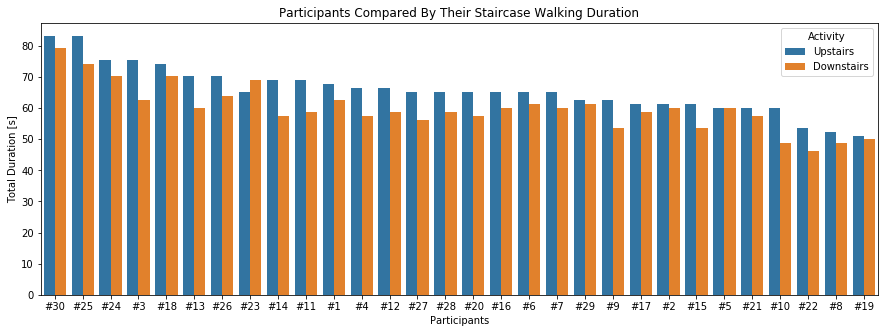

In [11]:
# Group the data by participant and compute total duration of staircase walking
mask = label.isin(['WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS'])
duration_df = (both_df[mask].groupby([label[mask], 'subject'])['Data'].count() * 1.28)

# Create plot
plot_data = duration_df.reset_index().sort_values('Data', ascending=False)
plot_data['Activity'] = plot_data['Activity'].map({'WALKING_UPSTAIRS':'Upstairs', 'WALKING_DOWNSTAIRS':'Downstairs'})

plt.figure(figsize=(15,5))
sns.barplot(data=plot_data, x='subject', y='Data', hue='Activity')
plt.title('Participants Compared By Their Staircase Walking Duration')
plt.xlabel('Participants')
plt.ylabel('Total Duration [s]')
plt.show()

Nearly all participants have more data for walking upstairs than downstairs. Assuming an equal number of up- and down-walks the **participants need longer walking upstairs.**<br>
Furthermore the range of the duration is narrow and adjusted to the conditions. A young person being ~50% fast in walking upstairs than an older one is reasonable.

### <a id=5.5>How Much Does The Up-/Downstairs Ratio Vary?</a>

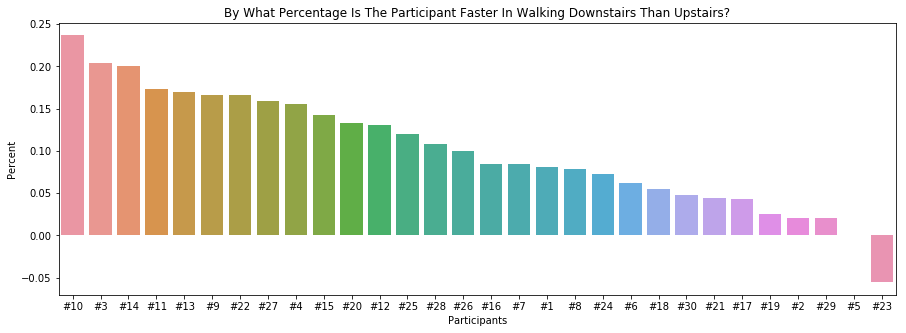

In [12]:
# Create data and plot
plt.figure(figsize=(15,5))
plot_data = ((duration_df.loc['WALKING_UPSTAIRS'] / duration_df.loc['WALKING_DOWNSTAIRS']) -1).sort_values(ascending=False)
sns.barplot(x=plot_data.index, y=plot_data)
plt.title('By What Percentage Is The Participant Faster In Walking Downstairs Than Upstairs?')
plt.xlabel('Participants')
plt.ylabel('Percent')
plt.show()

There is a wide range in between the participants for their **ratio of up-/down-walking.** Since this represents their physical condition I can imagine a **correlation to their age and health** (speculative).

### <a id=5.6>Are There Conspicuities In The Staircase Walking Duration Distribution?</a>

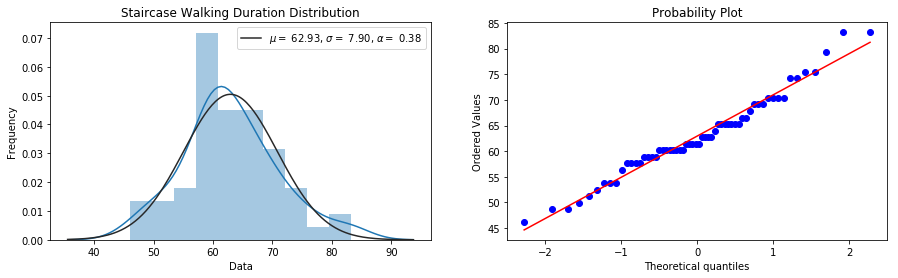

In [13]:
def plotSkew(x):
    # Fit label to norm
    (mu, sigma) = norm.fit(x)
    alpha = skew(x)

    fig, axarr = plt.subplots(1, 2, figsize=(15,4))

    # Plot label and fit
    sns.distplot(x , fit=norm, ax=axarr[0])
    axarr[0].legend(['$\mu=$ {:.2f}, $\sigma=$ {:.2f}, $\\alpha=$ {:.2f}'.format(mu, sigma, alpha)], loc='best')
    axarr[0].set_title('Staircase Walking Duration Distribution')
    axarr[0].set_ylabel('Frequency')

    # Plot probability plot
    res = probplot(x, plot=axarr[1])
    plt.show()
    
    
plotSkew(duration_df)

As aspected from most real world data the duration walking on the staircase is **normally distributed**

### <a id=5.7>Is There A Unique Walking Style For Each Participant?</a>

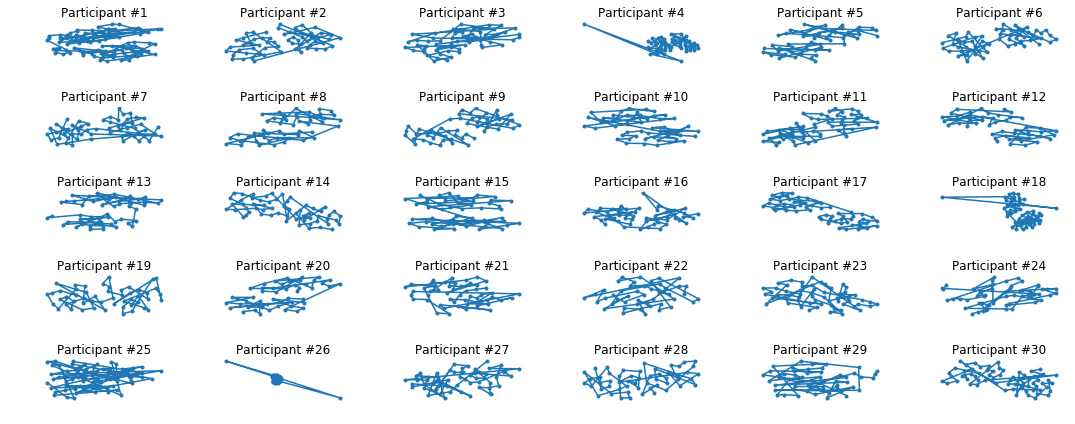

In [14]:
fig, axarr = plt.subplots(5, 6, figsize=(15,6))

for person in range(0, 30):
    # Get data
    single_person = both_df[(label=='WALKING') & (both_df['subject']=='#{}'.format(person+1))].drop(['subject', 'Data'], axis=1)
    # Scale data
    scl = StandardScaler()
    tsne_data = scl.fit_transform(single_person)
    # Reduce dimensions
    pca = PCA(n_components=0.9, random_state=3)
    tsne_data = pca.fit_transform(tsne_data)
    # Transform data
    tsne = TSNE(random_state=3)
    tsne_transformed = tsne.fit_transform(tsne_data)
    
    # Create plot
    axarr[person//6][person%6].plot(tsne_transformed[:,0], tsne_transformed[:,1], '.-')
    axarr[person//6][person%6].set_title('Participant #{}'.format(person+1))
    axarr[person//6][person%6].axis('off')
    
plt.tight_layout()
plt.show()

For this visualisation i am assuming the **datapoints were not shuffled** and are in the correct order (time series).

Visualising the walking structure for each participant you can see some **outliers** (e. g. #4,  #18 and #26) in the data, which **could be 'starting to walk', 'stopping' or 'stumble'.** Additional there are **two clusters for each participant.** How these clusters should be interpreted is not clear.<br>
It cannot be the steps for each foot, since there would be connections between the clusters for each alternating step. Due to the fact that there is (mostly) only a single connection between the clusters and each cluster has just about the same size I conclude **each cluster represents a single walking experiment.**

### <a id=5.8>How Long Does The Participant Walk?</a>

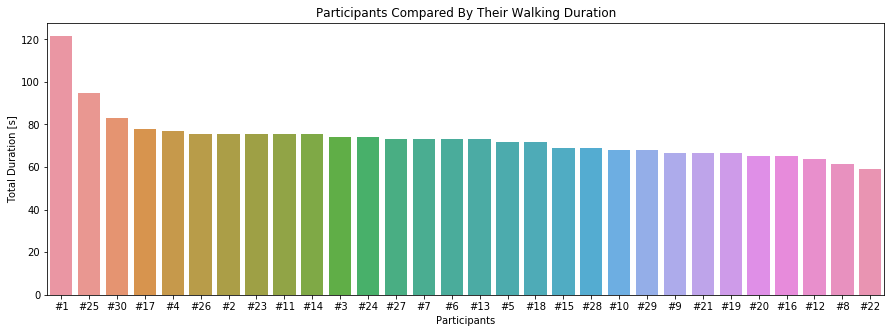

In [15]:
# Group the data by participant and compute total duration of walking
mask = label=='WALKING'
duration_df = (both_df[mask].groupby('subject')['Data'].count() * 1.28)

# Create plot
plot_data = duration_df.reset_index().sort_values('Data', ascending=False)

plt.figure(figsize=(15,5))
sns.barplot(data=plot_data, x='subject', y='Data')
plt.title('Participants Compared By Their Walking Duration')
plt.xlabel('Participants')
plt.ylabel('Total Duration [s]')
plt.show()

Since the duration of each participant walking is distributed over a range I assume the participants had a **fixed walking distance for their experiment** rather than a fixed duration.

### <a id=5.9>Is There A Unique Staircase Walking Style For Each Participant?</a>

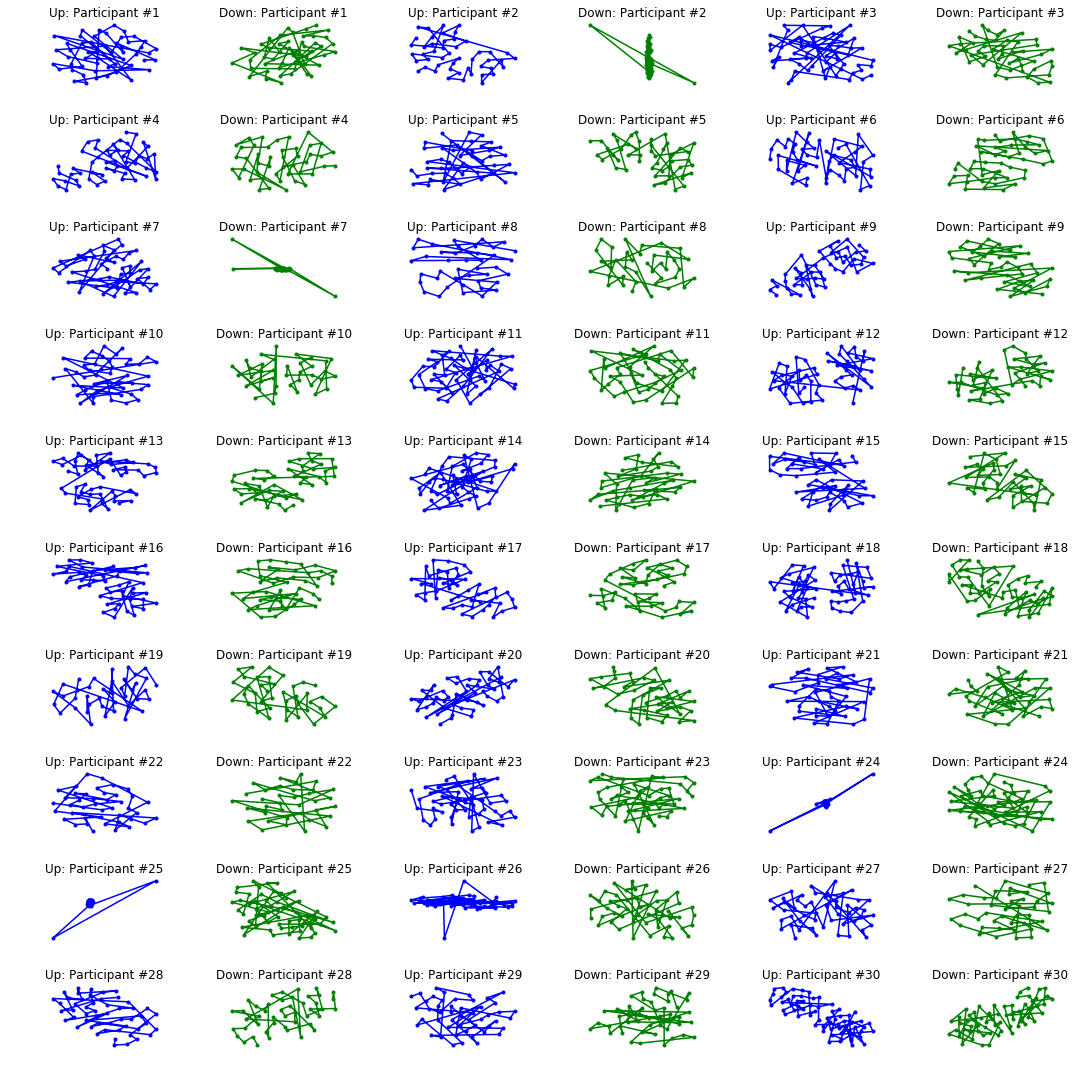

In [16]:
# Create subplots
fig, axarr = plt.subplots(10, 6, figsize=(15,15))

# Iterate over each participant
for person in range(0, 30):
    # Get data
    single_person_up = both_df[(label=='WALKING_UPSTAIRS') & (both_df['subject']=='#{}'.format(person+1))].drop(['subject', 'Data'], axis=1)
    single_person_down = both_df[(label=='WALKING_DOWNSTAIRS') & (both_df['subject']=='#{}'.format(person+1))].drop(['subject', 'Data'], axis=1)
    # Scale data
    scl = StandardScaler()
    tsne_data_up = scl.fit_transform(single_person_up)
    tsne_data_down = scl.fit_transform(single_person_down)
    # Reduce dimensions
    pca = PCA(n_components=0.9, random_state=3)
    tsne_data_up = pca.fit_transform(tsne_data_up)
    tsne_data_down = pca.fit_transform(tsne_data_down)
    # Transform data
    tsne = TSNE(random_state=3)
    tsne_transformed_up = tsne.fit_transform(tsne_data_up)
    tsne_transformed_down = tsne.fit_transform(tsne_data_down)
    
    # Create plot
    axarr[2*person//6][2*person%6].plot(tsne_transformed_up[:,0], tsne_transformed_up[:,1], '.b-')
    axarr[2*person//6][2*person%6].set_title('Up: Participant #{}'.format(person+1))
    axarr[2*person//6][2*person%6].axis('off')
    axarr[2*person//6][(2*person%6)+1].plot(tsne_transformed_down[:,0], tsne_transformed_down[:,1], '.g-')
    axarr[2*person//6][(2*person%6)+1].set_title('Down: Participant #{}'.format(person+1))
    axarr[2*person//6][(2*person%6)+1].axis('off')
    
plt.tight_layout()
plt.show()

In most of the plots a structure with **two clusters** is again recognizable. Going **up and down the stairs for two times** is likely for the experiment.<br>
I will review the durations for this assumption with a small experiment on my stairs.

## <a id=6>Exploring Personal Information</a>
### <a id=6.1>What Is The Walking Frequency Of A Single Participant?</a>

Thanks to the [Singular-Spectrum Analysis notebook](https://www.kaggle.com/jdarcy/introducing-ssa-for-time-series-decomposition) (SSA) from [jdarcy](https://www.kaggle.com/jdarcy) I could extract the main components of the walking style of the participants using only the euclidean norm of the three accelerometer axes.<br>
First of all I combined both walking experiments (clusters) of a single participant and tried to decompose the components.

In [ ]:
# Use SS class fro jdarcy
class SSA(object):    
    __supported_types = (pd.Series, np.ndarray, list)
    
    def __init__(self, tseries, L, save_mem=True):
        '''
        Decomposes the given time series with a singular-spectrum analysis. Assumes the values of the time series are
        recorded at equal intervals.
        
        Parameters
        ----------
        tseries : The original time series, in the form of a Pandas Series, NumPy array or list. 
        L : The window length. Must be an integer 2 <= L <= N/2, where N is the length of the time series.
        save_mem : Conserve memory by not retaining the elementary matrices. Recommended for long time series with
            thousands of values. Defaults to True.
        
        Note: Even if an NumPy array or list is used for the initial time series, all time series returned will be
        in the form of a Pandas Series or DataFrame object.
        '''
        
        # Tedious type-checking for the initial time series
        if not isinstance(tseries, self.__supported_types):
            raise TypeError('Unsupported time series object. Try Pandas Series, NumPy array or list.')
        
        # Checks to save us from ourselves
        self.N = len(tseries)
        if not 2 <= L <= self.N/2:
            raise ValueError('The window length must be in the interval [2, N/2].')
        
        self.L = L
        self.orig_TS = pd.Series(tseries)
        self.K = self.N - self.L + 1
        
        # Embed the time series in a trajectory matrix
        self.X = np.array([self.orig_TS.values[i:L+i] for i in range(0, self.K)]).T
        
        # Decompose the trajectory matrix
        self.U, self.Sigma, VT = np.linalg.svd(self.X)
        self.d = np.linalg.matrix_rank(self.X)
        
        self.TS_comps = np.zeros((self.N, self.d))
        
        if not save_mem:
            # Construct and save all the elementary matrices
            self.X_elem = np.array([ self.Sigma[i]*np.outer(self.U[:,i], VT[i,:]) for i in range(self.d) ])

            # Diagonally average the elementary matrices, store them as columns in array.           
            for i in range(self.d):
                X_rev = self.X_elem[i, ::-1]
                self.TS_comps[:,i] = [X_rev.diagonal(j).mean() for j in range(-X_rev.shape[0]+1, X_rev.shape[1])]
            
            self.V = VT.T
        else:
            # Reconstruct the elementary matrices without storing them
            for i in range(self.d):
                X_elem = self.Sigma[i]*np.outer(self.U[:,i], VT[i,:])
                X_rev = X_elem[::-1]
                self.TS_comps[:,i] = [X_rev.diagonal(j).mean() for j in range(-X_rev.shape[0]+1, X_rev.shape[1])]
            
            self.X_elem = 'Re-run with save_mem=False to retain the elementary matrices.'
            
            # The V array may also be very large under these circumstances, so we won't keep it.
            self.V = 'Re-run with save_mem=False to retain the V matrix.'
        
        # Calculate the w-correlation matrix.
        self.calc_wcorr()
            
    def components_to_df(self, n=0):
        '''
        Returns all the time series components in a single Pandas DataFrame object.
        '''
        if n > 0:
            n = min(n, self.d)
        else:
            n = self.d
        
        # Create list of columns - call them F0, F1, F2, ...
        cols = ['F{}'.format(i) for i in range(n)]
        return pd.DataFrame(self.TS_comps[:, :n], columns=cols, index=self.orig_TS.index)
            
    
    def reconstruct(self, indices):
        '''
        Reconstructs the time series from its elementary components, using the given indices. Returns a Pandas Series
        object with the reconstructed time series.
        
        Parameters
        ----------
        indices: An integer, list of integers or slice(n,m) object, representing the elementary components to sum.
        '''
        if isinstance(indices, int): indices = [indices]
        
        ts_vals = self.TS_comps[:,indices].sum(axis=1)
        return pd.Series(ts_vals, index=self.orig_TS.index)
    
    def calc_wcorr(self):
        '''
        Calculates the w-correlation matrix for the time series.
        '''
             
        # Calculate the weights
        w = np.array(list(np.arange(self.L)+1) + [self.L]*(self.K-self.L-1) + list(np.arange(self.L)+1)[::-1])
        
        def w_inner(F_i, F_j):
            return w.dot(F_i*F_j)
        
        # Calculated weighted norms, ||F_i||_w, then invert.
        F_wnorms = np.array([w_inner(self.TS_comps[:,i], self.TS_comps[:,i]) for i in range(self.d)])
        F_wnorms = F_wnorms**-0.5
        
        # Calculate Wcorr.
        self.Wcorr = np.identity(self.d)
        for i in range(self.d):
            for j in range(i+1,self.d):
                self.Wcorr[i,j] = abs(w_inner(self.TS_comps[:,i], self.TS_comps[:,j]) * F_wnorms[i] * F_wnorms[j])
                self.Wcorr[j,i] = self.Wcorr[i,j]
    
    def plot_wcorr(self, min=None, max=None):
        '''
        Plots the w-correlation matrix for the decomposed time series.
        '''
        if min is None:
            min = 0
        if max is None:
            max = self.d
        
        if self.Wcorr is None:
            self.calc_wcorr()
        
        ax = plt.imshow(self.Wcorr)
        plt.xlabel(r'$\tilde{F}_i$')
        plt.ylabel(r'$\tilde{F}_j$')
        plt.colorbar(ax.colorbar, fraction=0.045)
        ax.colorbar.set_label('$W_{i,j}$')
        plt.clim(0,1)
        
        # For plotting purposes:
        if max == self.d:
            max_rnge = self.d-1
        else:
            max_rnge = max
        
        plt.xlim(min-0.5, max_rnge+0.5)
        plt.ylim(max_rnge+0.5, min-0.5)
        
        
# Euclidean norm of the acceleration
walking_series = both_df[(label=='WALKING') & (both_df['subject']=='#1')][['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z']].reset_index(drop=True)
walking_series = (walking_series**2).sum(axis=1)**0.5

# Decomposing the series
series_ssa = SSA(walking_series, 30)

# Plotting the decomposition
plt.figure(figsize=(15,5))
series_ssa.reconstruct(0).plot()
series_ssa.reconstruct([1,2]).plot()
series_ssa.reconstruct([3,4]).plot()
series_ssa.orig_TS.plot(alpha=0.4)
plt.title('Walking Time Series: 3 Main Components')
plt.xlabel(r'$t$ (s)')
plt.ylabel('Accelerometer')
legend = [r'$\tilde{{F}}^{{({0})}}$'.format(i) for i in range(3)] + ['Original Series']
plt.legend(legend);

You can see the original data from the accelerometer can be decomposed into three main components. The first one (blue) reveals the overall constant trend. The other two **(yellow, green) represent the oscillating walking frequencies.**<br>
The **frequency change** in the middle of the plot underlines the assumption of **two distinct walking experiments.** Furthermore it can be stated that both experiments had **different walking speeds** (e. g. walking and running)

### <a id=6.2>What Is The Walking Frequency Of Both Found Speeds?</a>

Both experiments of a single person have been split and will be analysed separately.

In [ ]:
# Both walking styles from a single participant
style1 = both_df.loc[78:124][['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z']].reset_index(drop=True)
style1 = ((style1**2).sum(axis=1)**0.5)
style1 -= style1.mean()
style2 = both_df.loc[248:295][['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z']].reset_index(drop=True)
style2 = (style2**2).sum(axis=1)**0.5
style2 -= style2.mean()

# Decompose
style1_ssa = SSA(style1, 20)
style2_ssa = SSA(style2, 20)

# Create plot
fig, axarr = plt.subplots(1, 2, figsize=(15,5))

# Plotting the decomposition style 1
(style1_ssa.reconstruct([0,1])-0.1).plot(ax=axarr[0])
style1_ssa.orig_TS.plot(alpha=0.4, ax=axarr[0])
axarr[0].set_title('Walking Experiment/Style 1: Main Component')
axarr[0].set_xlabel(r'$t$ (s)')
axarr[0].set_ylabel('Standardised Accelerometer')
legend = [r'$\tilde{{F}}^{{({0})}}$'.format(i) for i in range(1)] + ['Original Series']
axarr[0].legend(legend);

# Plotting the decomposition style 2
(style2_ssa.reconstruct([0,1])-0.1).plot(ax=axarr[1])
style2_ssa.orig_TS.plot(alpha=0.4, ax=axarr[1])
axarr[1].set_title('Walking Experiment/Style 2: Main Component')
axarr[1].set_xlabel(r'$t$ (s)')
axarr[1].set_ylabel('Standardised Accelerometer')
legend = [r'$\tilde{{F}}^{{({0})}}$'.format(i) for i in range(3)] + ['Original Series']
axarr[1].legend(legend);

Decomposing both experiments separatly offers highly improved results. Fitting a sin-curve to the **main component** should reveal the **step frequency of the participant.**

In [ ]:
# Function to fit a sinus
def fit_sin(tt, yy):
    '''Fit sin to the input time sequence, and return fitting parameters "amp", "omega", "phase", "offset", "freq", "period" and "fitfunc"'''
    tt = np.array(tt)
    yy = np.array(yy)
    # Assume uniform spacing
    ff = np.fft.fftfreq(len(tt), (tt[1]-tt[0]))
    Fyy = abs(np.fft.fft(yy))
    # Exclude the zero frequency "peak"
    guess_freq = abs(ff[np.argmax(Fyy[1:])+1])
    guess_amp = np.std(yy) * 2.**0.5
    guess_offset = np.mean(yy)
    guess = np.array([guess_amp, 2.*np.pi*guess_freq, 0., guess_offset])

    # Sinus
    def sinfunc(t, A, w, p, c):  
        return A * np.sin(w*t + p) + c
    
    # Fit sinus
    popt, pcov = curve_fit(sinfunc, tt, yy, p0=guess)
    A, w, p, c = popt
    f = w/(2.*pi)
    fitfunc = lambda t: A * np.sin(w*t + p) + c
    return {"amp": A, "omega": w, "phase": p, "offset": c, "freq": f, "period": 1./f, "fitfunc": fitfunc, "maxcov": np.max(pcov), "rawres": (guess,popt,pcov)}

# Get data
main_style1 = style1_ssa.reconstruct([0, 1])
tt1 = main_style1.index
yy1 = main_style1.values
tt_res1 = np.arange(0, 48, 0.1)
# Fit data
res1 = fit_sin(tt1, yy1)

# Get data
main_style2 = style2_ssa.reconstruct([0, 1])
tt2 = main_style2.index
yy2 = main_style2.values
tt_res2 = np.arange(0, 48, 0.1)
# Fit data
res2 = fit_sin(tt2, yy2)

# Plot data
fig, axarr = plt.subplots(1, 2, figsize=(15,5))

# Plot data
axarr[0].plot(tt1, yy1, "-ok", label='Data', linewidth=2)
axarr[0].plot(tt_res1, res1['fitfunc'](tt_res1), "r-", label='Fit', linewidth=2)
axarr[0].set_title('Style 1 Walking Fit: {:.2f} Steps Per Second'.format((res1['omega']*1.28)/(pi)))
axarr[0].legend(loc="best")

axarr[1].plot(tt2, yy2, "-ok", label='Data', linewidth=2)
axarr[1].plot(tt_res2, res2['fitfunc'](tt_res2), "r-", label='Fit', linewidth=2)
axarr[1].set_title('Style 2 Walking Fit: {:.2f} Steps Per Second'.format((res2['omega']*1.28)/(pi)))
axarr[1].legend(loc="best")
plt.show()

**Fitting a sinus curve** to the main component of the walking experiments of participant #1 reveals the **computed speed of both experients differed by a factor of nearly 2.**<br>
Since the second speed is suspiciously low there could be a sampling problem and information could have been irrevocably lost while aggregating the dataset ([Sampling Theorem](https://en.wikipedia.org/wiki/Nyquist%E2%80%93Shannon_sampling_theorem)). Potentially the datapoints are to wide spread to reconstruct the underlying frequency in a correct way. This will be compared to a self-experiment in the next section to back up these statements.

In [ ]:
# Get data
tsne_data = both_df[label=='WALKING'].copy()
data_data = tsne_data.pop('Data')
subject_data = tsne_data.pop('subject')

# Scale data
scl = StandardScaler()
tsne_data = scl.fit_transform(tsne_data)

# Reduce dimensions
pca = PCA(n_components=0.9, random_state=3)
tsne_data = pca.fit_transform(tsne_data)

# Transform data
tsne = TSNE(random_state=3)
tsne_transformed = tsne.fit_transform(tsne_data)


# Create subplots
fig, axarr = plt.subplots(1, 1, figsize=(15,10))

### Plot Subjects
# Get colors
n = subject_data.unique().shape[0]
colormap = get_cmap('gist_ncar')
colors = [rgb2hex(colormap(col)) for col in np.arange(0, 1.01, 1/(n-1))]

for i, group in enumerate(subject_data.unique()):
    # Mask to separate sets
    mask = (subject_data==group).values
    axarr.scatter(x=tsne_transformed[mask][:,0], y=tsne_transformed[mask][:,1], c=colors[i], alpha=0.5, label=group)

axarr.set_title('TSNE Walking Style By Participant')
plt.show()

For the decomposition I have only shown a single participant with the two walking styles. By computing a t-SNE visualization of the walking of all participants you can see two clusters for each participant (Some more distinct than others). Therefore the option of splitting the styles by decomposition suggests itself.

### <a id=6.3>What Are The Frequencies In A Self-Experiment?</a>

I recorded a few examples for the frequencies in a self-experiment to compare the extracted frequencies from the smartphones with real world data. For that reason I counted the steps while walking and m[](http://)easured the corresponding time.

In [ ]:
data = [['Walking Downstairs', 8.82, 15], 
        ['Walking Downstairs', 9.49, 15], 
        ['Walking Downstairs', 10.06, 15], 
        ['Walking Downstairs', 8.77, 15], 
        ['Walking Fast', 42.25, 80], 
        ['Walking Slow', 62.64, 80], 
        ['Walking Upstairs', 11.16, 15], 
        ['Walking Upstairs', 12.06, 15], 
        ['Walking Upstairs', 11.08, 15], 
        ['Walking Upstairs', 11.12, 15], 
        ['Walking Upstairs', 42.47, 60],
        ['Walking Downstairs', 10.334, 15],
        ['Walking Downstairs', 10.785, 15],
        ['Walking Downstairs', 10.487, 15],
        ['Walking Slow', 165.449, 200],
        ['Walking Fast', 115.360, 200],
        ['Walking Upstairs', 11.823, 15],
        ['Walking Upstairs', 11.872, 15],
        ['Walking Upstairs', 11.928, 15],
        ['Walking Upstairs', 11.351, 15]]

df = pd.DataFrame(data, columns=['Activity', 'Duration', 'Steps'])
activity_df = df.groupby('Activity').sum()
activity_df['Frequency'] = activity_df['Steps'] / activity_df['Duration']
activity_df.sort_values('Frequency', ascending=False)['Frequency'].plot(kind='barh', grid=True, figsize=(15,5))
plt.title('Self-Experiment: Steps Per Second')
plt.show()

**Please have in mind:** since the dataset and my experiment both only provide a small amount of data the variance of the results can be high.

The first walking speed in the dataset could correspond to my **slow walking style (Dataset: 0.94 Steps/Second, Self-Experiment: 1.23 Steps/Second)**.<br>
In contrast to this the **second walking speed in the dataset raises some issues. Walking with 0.50 Steps/Second seems highly unlikely** after trying it for myself. Furthermore a fast walking style has around ~1.5 steps per aggregated datapoint (1.28 Seconds/Point). Therefore a **fast walking style cound hardly be extracted with this small amount of data**. Since the sinus can be fitted to the data the correct step frequency can be found within integral multiples of the found frequency (0.5/1.0/1.5/... Steps/Second).
<br>A dataset with raw data or a higher sampling frequency for the points should reveal some more insights regarding the faster walking styles.


## <a id=7>Conclusion</a>

Within a short time **(1-1.5 min)** the smartphone has enough data to determine what its user is doing (**95%**: 6 activities) or who the user is (**Walking 94%**: 30 participants) and even the basics of a persons specific walking style (**Slow steps per second**). By linking this insights to more personal data of the participants extensiv options open up.<br>
In addition this insights have been extracted from only two smartphone sensors which probably could be accessed by most of our Apps.<br>
**Let us not consider for how long we have been carrying our gadgets around.**

I hope this was interesting for you.<br>
Have a good day.